In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import plotly.express as px
import plotly.io as pio 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adv-data/advertising.csv


In [2]:
def plotting(series):
    fig, ax = plt.subplots(figsize=(14, 6))  # Just one subplot
    sns.histplot(series, kde=True, ax=ax, bins=30, color='green')

    plt.tight_layout()
    plt.show()

In [3]:
def piechart_series(series, labels=None, title='Pie Chart', figsize=(8, 8)):
    """
    Plots a pie chart for the given series.

    Parameters:
    - series: pandas Series containing the data.
    - labels: List of labels for the pie chart segments (optional).
    - title: Title of the pie chart (default is 'Pie Chart').
    - figsize: Size of the pie chart (default is (8, 8)).

    Returns:
    - None (plots the pie chart).
    """
    # Count the occurrences of each category in the series
    counts = series.value_counts()

    # If labels are not provided, use the unique values of the series
    if labels is None:
        labels = counts.index.tolist()

    # Plot the pie chart
    plt.figure(figsize=figsize)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(counts)))
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
    plt.show()

In [4]:
def piechart(data, column, labels=None, title='Pie Chart', figsize=(8, 8)):
    """
    Plots a pie chart for the given column in the dataset.

    Parameters:
    - data: pandas DataFrame containing the data.
    - column: The column name for which you want to create the pie chart.
    - labels: List of labels for the pie chart segments (optional).
    - title: Title of the pie chart (default is 'Pie Chart').
    - figsize: Size of the pie chart (default is (8, 8)).

    Returns:
    - None (plots the pie chart).
    """
    # Count the occurrences of each category in the column
    counts = data[column].value_counts()

    # If labels are not provided, use the unique values of the column
    if labels is None:
        labels = counts.index.tolist()

    # Plot the pie chart
    plt.figure(figsize=figsize)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(counts)))
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
    plt.show()


In [5]:
dataset=pd.read_csv("/kaggle/input/adv-data/advertising.csv")

In [6]:
print("No. of Datapoints in the Dataset: ",dataset.shape[0])
print("No. of Columns in the Dataset initially: ",dataset.shape[1])

No. of Datapoints in the Dataset:  1000
No. of Columns in the Dataset initially:  10


In [7]:
dataset.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


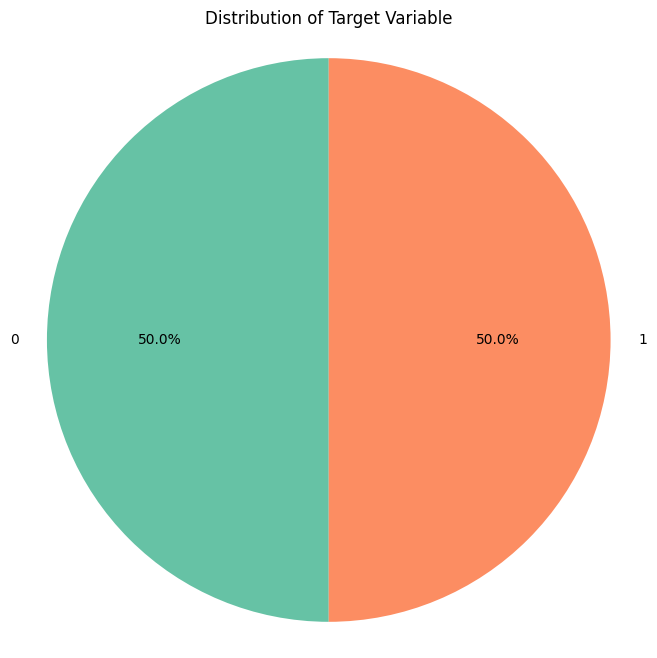

In [8]:
piechart(dataset,'Clicked on Ad',title='Distribution of Target Variable')

# EDA

## 1) City and Country

In [9]:
pio.renderers.default = 'iframe'  # or 'iframe' if notebook doesn't work


# Group by country and Clicked on Ad
grouped = dataset.groupby(['Country', 'Clicked on Ad']).size().reset_index(name='Count')

# Plot
fig = px.scatter_geo(grouped,
                     locations="Country",
                     locationmode="country names",
                     color="Clicked on Ad",
                     size="Count",
                     projection="natural earth",
                     title="Ad Clicks by Country",
                     color_discrete_map={0: 'blue', 1: 'red'})

fig.show()

In [10]:
clicked_df = dataset[dataset['Clicked on Ad'] == 1]

# Count clicks per country
clicks_by_country = clicked_df['Country'].value_counts().reset_index()
clicks_by_country.columns = ['Country', 'Clicks']

# Plot choropleth
fig = px.choropleth(clicks_by_country,
                    locations="Country",
                    locationmode="country names",
                    color="Clicks",
                    color_continuous_scale="Reds",
                    title="Heatmap of Ad Clicks by Country")

fig.show()

#### Observation: It is observed that the Country data is not scattered as expected according to population suggesting the country have been randomly alloted, or the dataset has been sliced such as to include almost every country, Hence, Including the country as feature does not make any sense (Very scarce datapoints spread across all the countries)

#### These charts will not be visible in Github Preview... Please visit the original Link of the Notebooks given in the Readme.md file to see the above charts(Recommended)

#### Observation: An Attempt was made to fetch the latitude and Longitude of Cities from which the data belongs, It was found that the city names are fictional and generated by logic: 
They appear to be generated using a combination of:
1. Common English first names or surnames (e.g., Jessica, Michael, Travis, Benjamin, Hernandez)
2. Typical suffixes used in city or town names (e.g., -ville, -town, -port, -bury, -land, -furt, -chester)

## 2) Creating Feature out of Ad Topic Line

####  TF-IDF Vectorizer Available in Scikitlearn has been used 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

/tmp/ipykernel_13/439213006.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_13/439213006.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in 

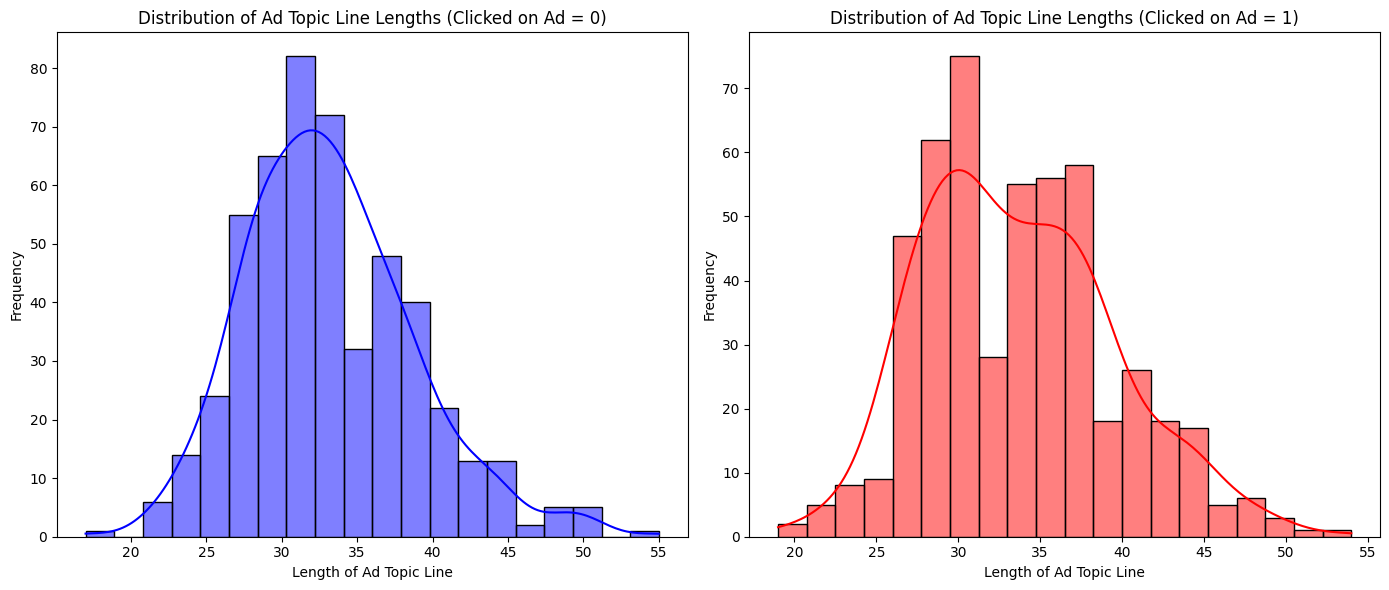

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create two subsets based on Clicked on Ad (0 and 1)
clicked_0 = dataset[dataset['Clicked on Ad'] == 0]
clicked_1 = dataset[dataset['Clicked on Ad'] == 1]

# Calculate the lengths for the Ad Topic Line
clicked_0['ad_topic_line_length'] = clicked_0['Ad Topic Line'].apply(lambda x: len(x))
clicked_1['ad_topic_line_length'] = clicked_1['Ad Topic Line'].apply(lambda x: len(x))

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Clicked on Ad = 0
sns.histplot(clicked_0['ad_topic_line_length'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Ad Topic Line Lengths (Clicked on Ad = 0)')
axes[0].set_xlabel('Length of Ad Topic Line')
axes[0].set_ylabel('Frequency')

# Plot for Clicked on Ad = 1
sns.histplot(clicked_1['ad_topic_line_length'], bins=20, kde=True, color='red', ax=axes[1])
axes[1].set_title('Distribution of Ad Topic Line Lengths (Clicked on Ad = 1)')
axes[1].set_xlabel('Length of Ad Topic Line')
axes[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


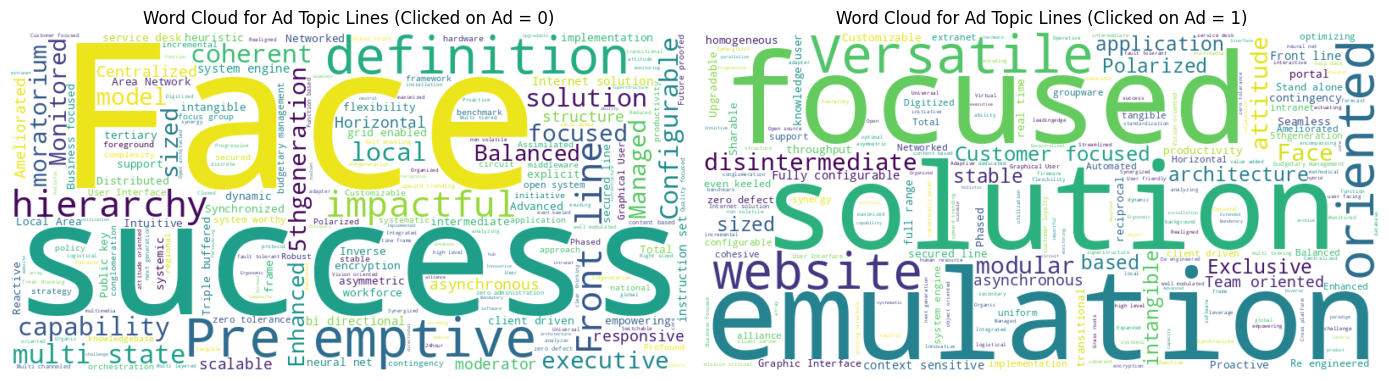

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create subsets for Clicked on Ad = 0 and Clicked on Ad = 1
clicked_0 = dataset[dataset['Clicked on Ad'] == 0]
clicked_1 = dataset[dataset['Clicked on Ad'] == 1]

# Join all ad topic lines into one large text for each subset
text_0 = ' '.join(clicked_0['Ad Topic Line'].dropna())
text_1 = ' '.join(clicked_1['Ad Topic Line'].dropna())

# Create word clouds for both
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot word cloud for Clicked on Ad = 0
axes[0].imshow(wordcloud_0, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud for Ad Topic Lines (Clicked on Ad = 0)')

# Plot word cloud for Clicked on Ad = 1
axes[1].imshow(wordcloud_1, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud for Ad Topic Lines (Clicked on Ad = 1)')

# Show the plots
plt.tight_layout()
plt.show()


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

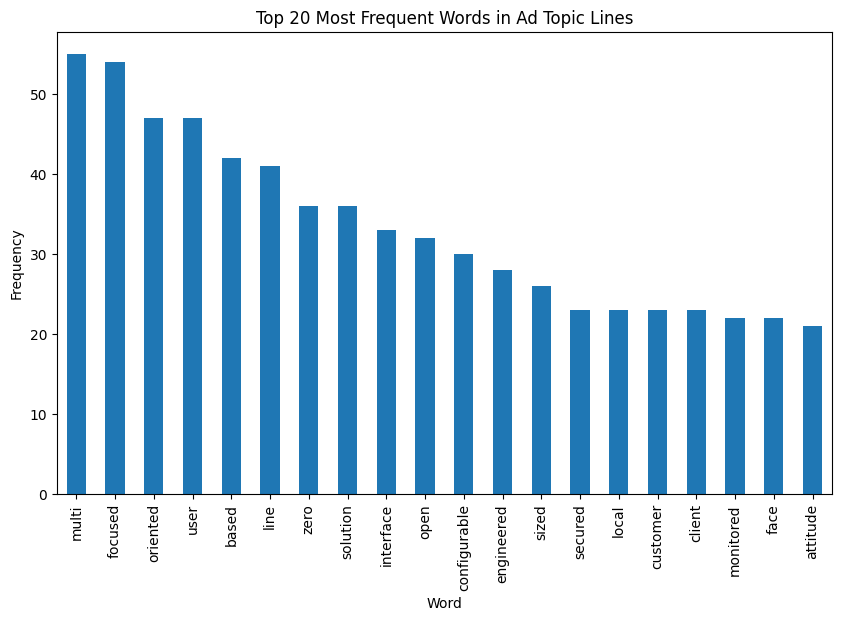

In [15]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(dataset['Ad Topic Line'].dropna())

# Convert to DataFrame and view the top words
top_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum(axis=0)
top_words = top_words.sort_values(ascending=False)

# Plot the top words
top_words.head(20).plot(kind='bar', figsize=(10, 6))
plt.title('Top 20 Most Frequent Words in Ad Topic Lines')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

#### Observation: 

## 3) Timestamp

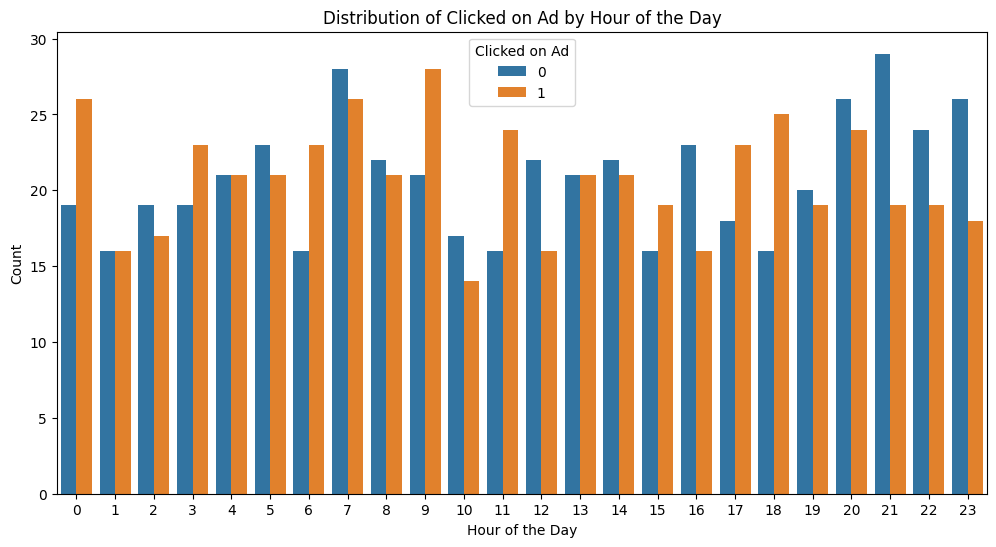

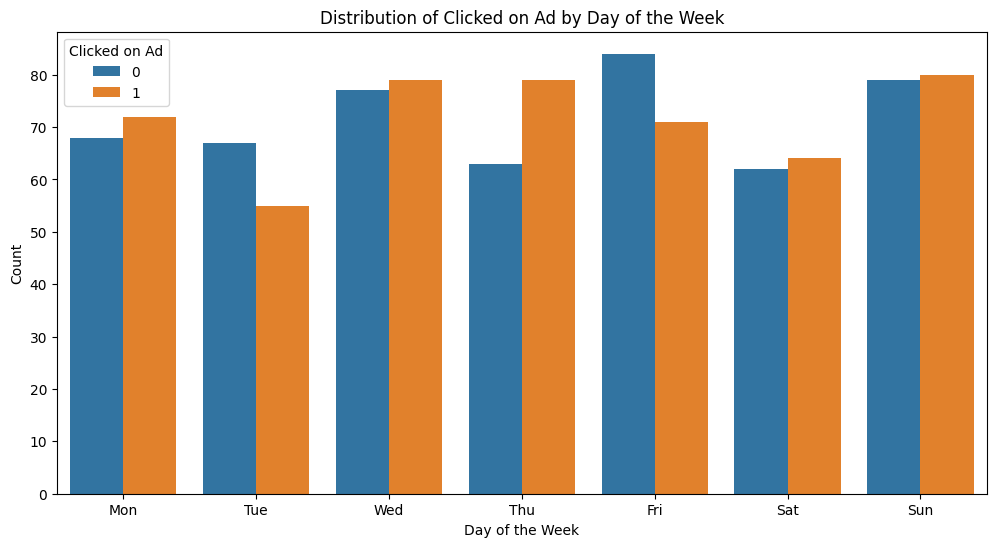

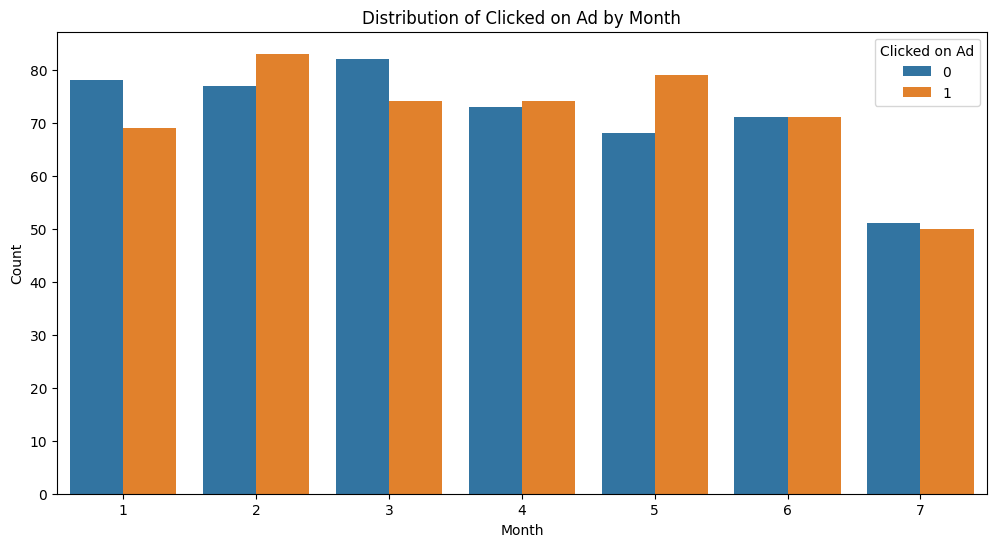

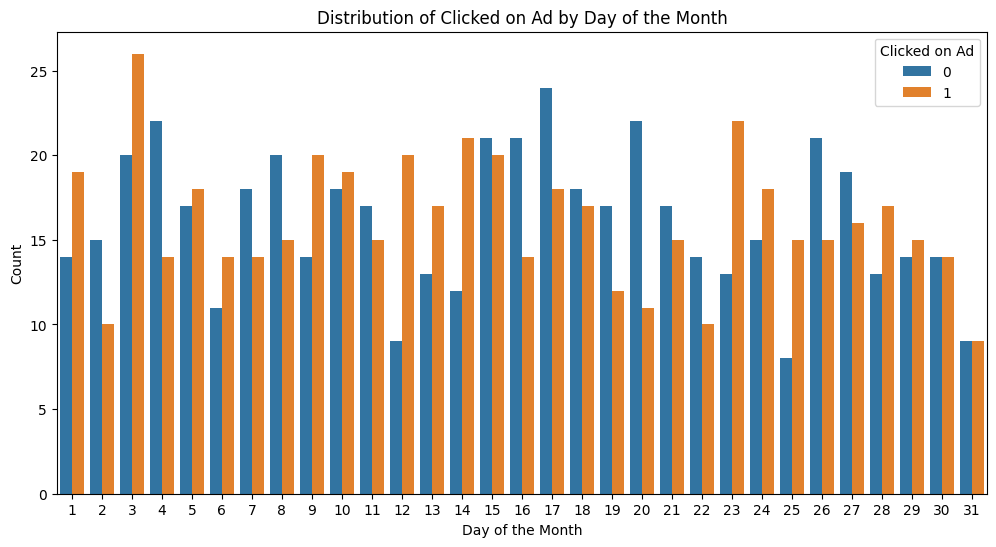

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Timestamp' is in datetime format
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

# Extract useful time-related features
dataset['Hour'] = dataset['Timestamp'].dt.hour
dataset['DayOfWeek'] = dataset['Timestamp'].dt.dayofweek  # Monday=0, Sunday=6
dataset['Month'] = dataset['Timestamp'].dt.month
dataset['Day'] = dataset['Timestamp'].dt.day
dataset['Year'] = dataset['Timestamp'].dt.year

# EDA on how the time of day (Hour) affects Clicked on Ad (0 or 1)
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset, x='Hour', hue='Clicked on Ad')
plt.title('Distribution of Clicked on Ad by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.show()

# EDA on how the Day of the Week affects Clicked on Ad (0 or 1)
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset, x='DayOfWeek', hue='Clicked on Ad')
plt.title('Distribution of Clicked on Ad by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# EDA on how the Month affects Clicked on Ad (0 or 1)
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset, x='Month', hue='Clicked on Ad')
plt.title('Distribution of Clicked on Ad by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

# EDA on how the Day of the Month affects Clicked on Ad (0 or 1)
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset, x='Day', hue='Clicked on Ad')
plt.title('Distribution of Clicked on Ad by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.show()


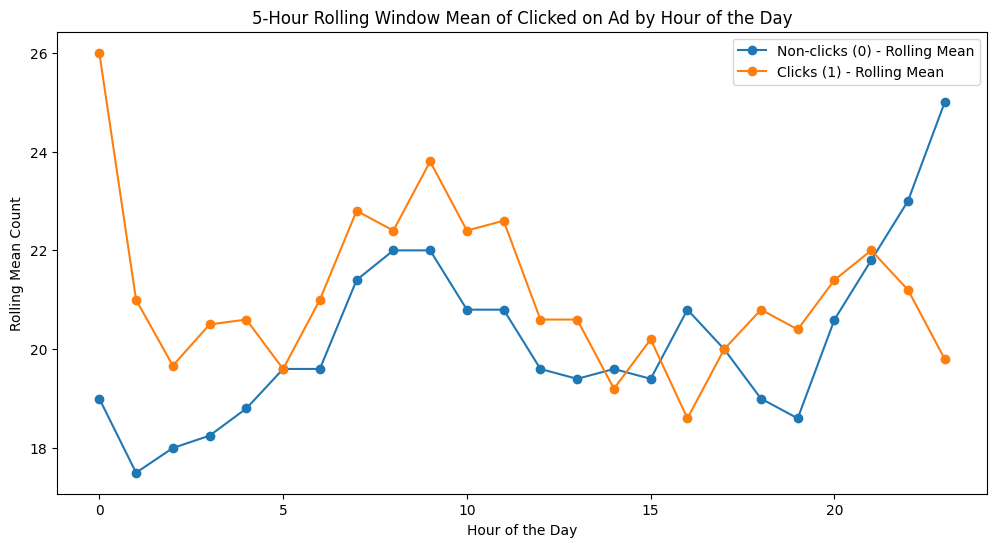

In [17]:
hourly_clicks = dataset.groupby(['Hour', 'Clicked on Ad']).size().unstack(fill_value=0)

# Apply 4-hour rolling window mean to smooth the data
rolling_clicks_0 = hourly_clicks[0].rolling(window=5, min_periods=1).mean()
rolling_clicks_1 = hourly_clicks[1].rolling(window=5, min_periods=1).mean()

# Plot using plt.plot
plt.figure(figsize=(12, 6))

# Plot for Clicked on Ad = 0 (non-clicks) with rolling mean
plt.plot(rolling_clicks_0.index, rolling_clicks_0, label='Non-clicks (0) - Rolling Mean', marker='o')

# Plot for Clicked on Ad = 1 (clicks) with rolling mean
plt.plot(rolling_clicks_1.index, rolling_clicks_1, label='Clicks (1) - Rolling Mean', marker='o')

# Title and labels
plt.title('5-Hour Rolling Window Mean of Clicked on Ad by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Rolling Mean Count')
plt.legend()

plt.show()

In [18]:
import pandas as pd

# Convert the Timestamp column to datetime format if it's not already
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

# Weekend feature (1 if weekend, 0 if not)
dataset['Weekend'] = (dataset['Timestamp'].dt.weekday >= 5).astype(int)  # Saturday (5) and Sunday (6)

# Time of day feature
dataset['Hour'] = dataset['Timestamp'].dt.hour

# Define time periods: Night (0-6 hrs), Morning (6-12 hrs), Afternoon (12-18 hrs), Evening (18-24 hrs)
def time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

dataset['Time_of_Day'] = dataset['Hour'].apply(time_of_day)

# Month part feature: 'Month Start', 'Month Mid', 'Month End'
dataset['Day'] = dataset['Timestamp'].dt.day

def month_part(day):
    if 1 <= day <= 10:
        return 'Month Start'
    elif 11 <= day <= 20:
        return 'Month Mid'
    else:
        return 'Month End'

dataset['Month_Part'] = dataset['Day'].apply(month_part)

# Display the first few rows of the dataset with the new features
dataset[['Timestamp', 'Weekend', 'Time_of_Day', 'Month_Part']].head()


,Timestamp,Weekend,Time_of_Day,Month_Part
0,2016-03-27 00:53:11,1,Night,Month End
1,2016-04-04 01:39:02,0,Night,Month Start
2,2016-03-13 20:35:42,1,Evening,Month Mid
3,2016-01-10 02:31:19,1,Night,Month Start
4,2016-06-03 03:36:18,0,Night,Month Start


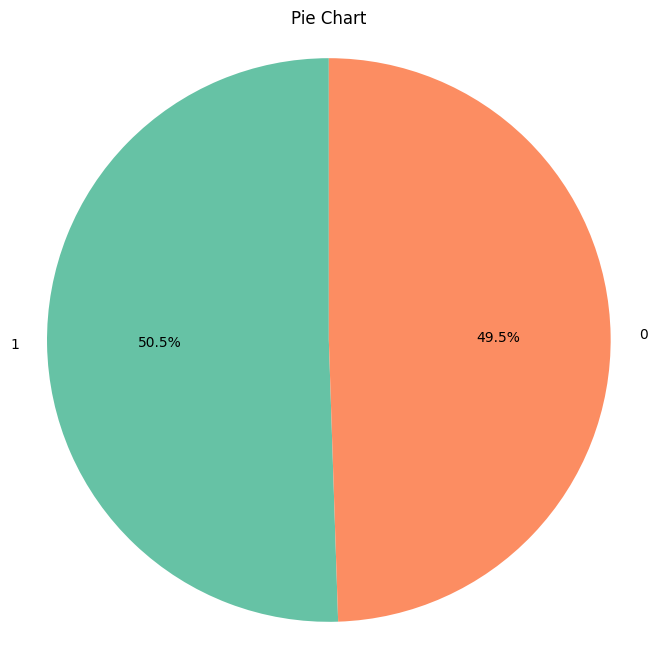

In [19]:
piechart_series(dataset[dataset['Weekend']==1]['Clicked on Ad'])

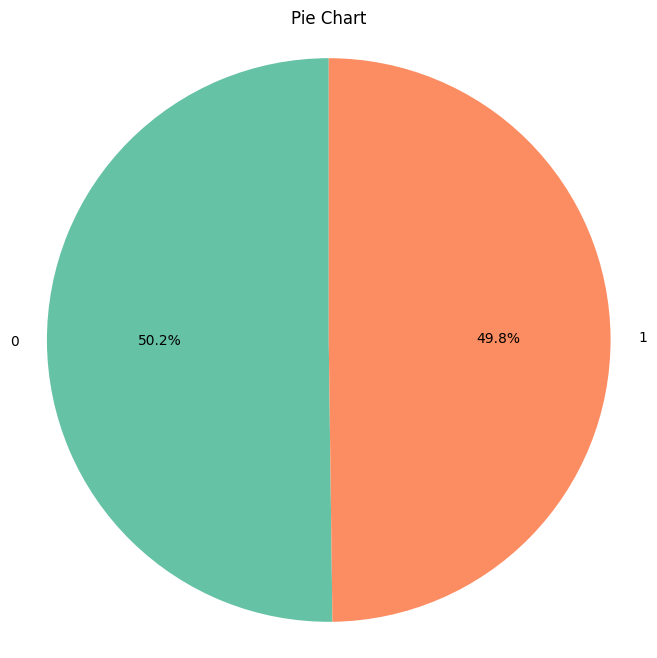

In [20]:
piechart_series(dataset[dataset['Weekend']==0]['Clicked on Ad'])

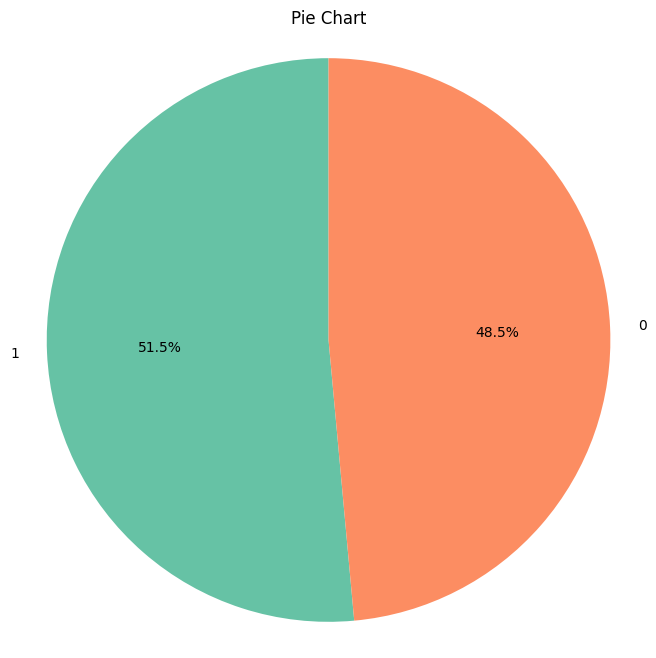

In [21]:
piechart_series(dataset[dataset['Time_of_Day']=='Night']['Clicked on Ad'])

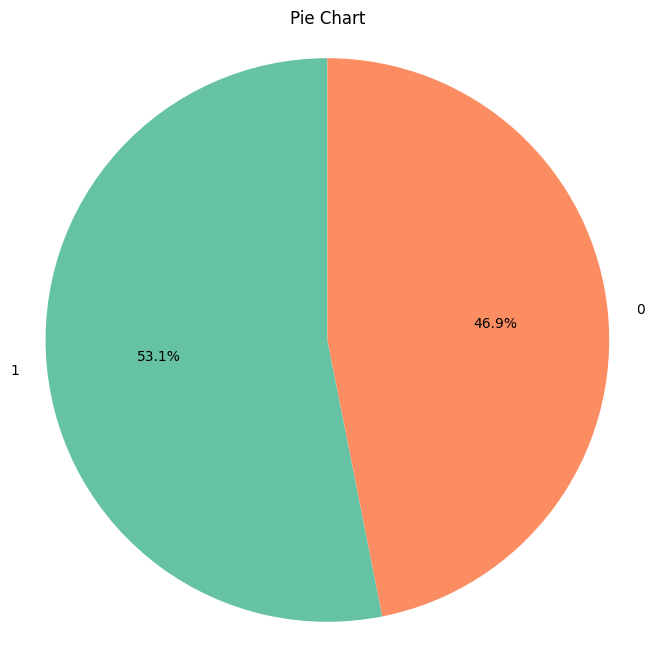

In [22]:
piechart_series(dataset[dataset['Time_of_Day']=='Morning']['Clicked on Ad'])

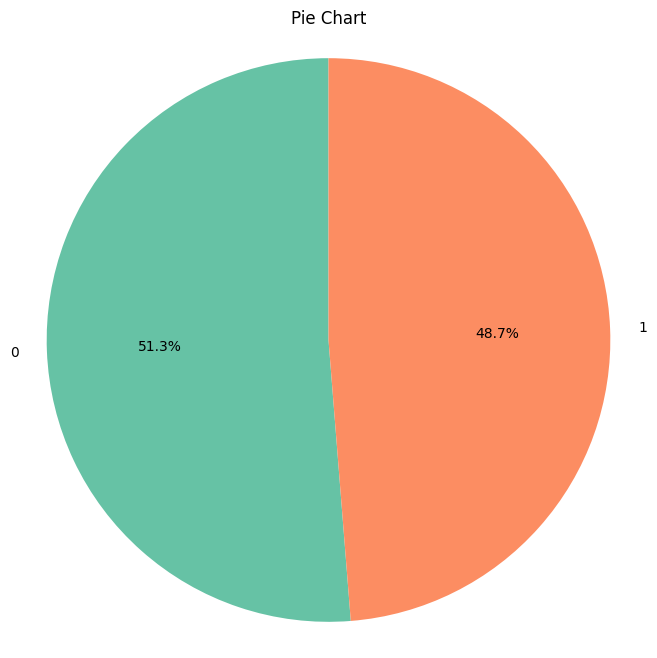

In [23]:
piechart_series(dataset[dataset['Time_of_Day']=='Afternoon']['Clicked on Ad'])

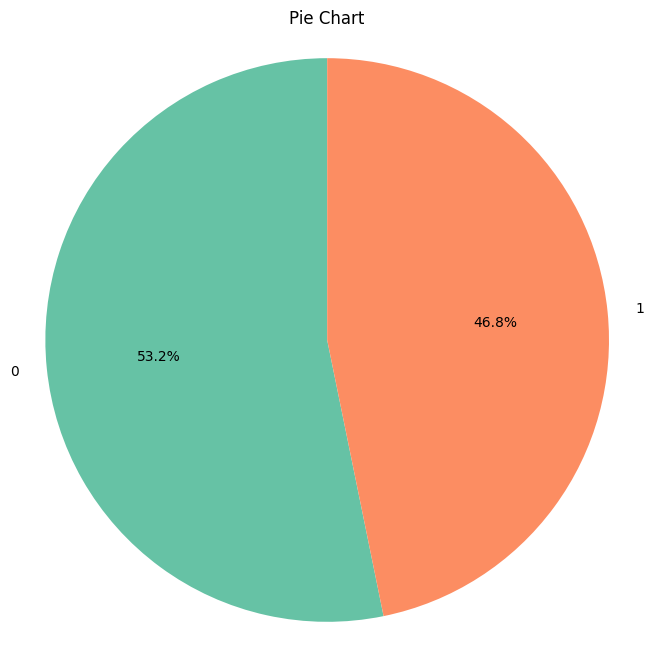

In [24]:
piechart_series(dataset[dataset['Time_of_Day']=='Evening']['Clicked on Ad'])

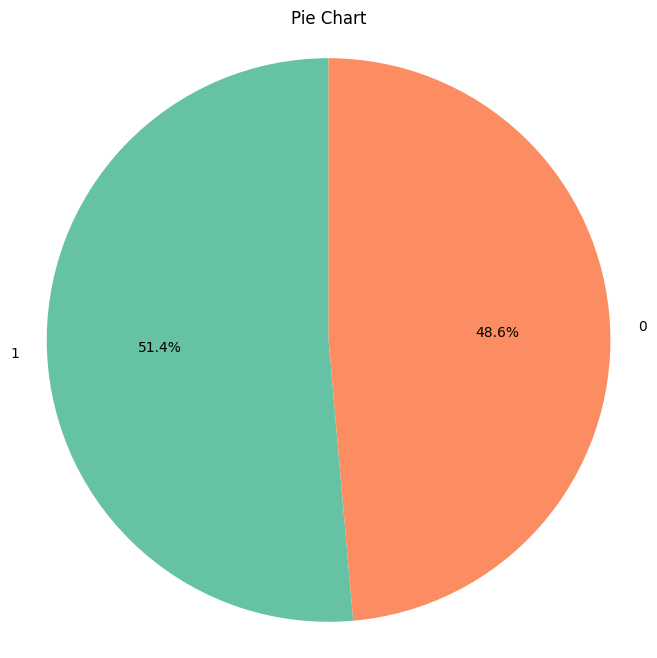

In [25]:
piechart_series(dataset[dataset['Month_Part']=='Month End']['Clicked on Ad'])

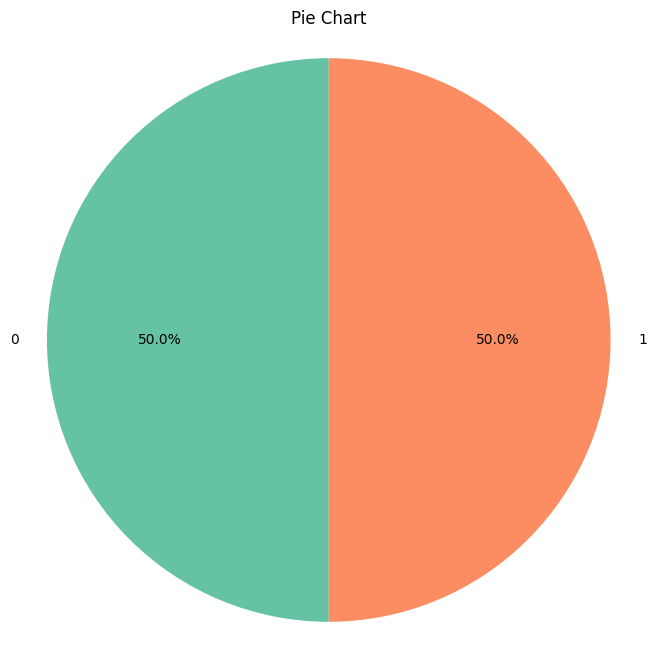

In [26]:
piechart_series(dataset[dataset['Month_Part']=='Month Start']['Clicked on Ad'])

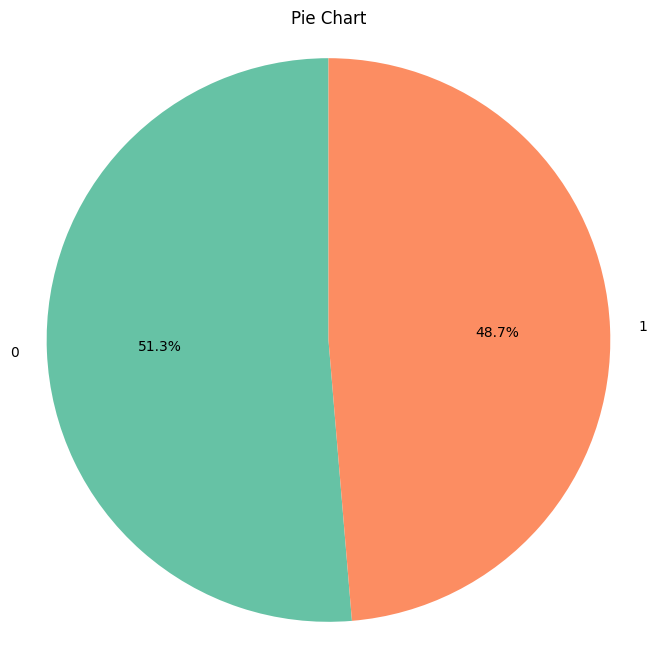

In [27]:
piechart_series(dataset[dataset['Month_Part']=='Month Mid']['Clicked on Ad'])

#### Observation: It is observed that there is only one significant feature that is the Time_of_the_Day Feature

## 4) Male

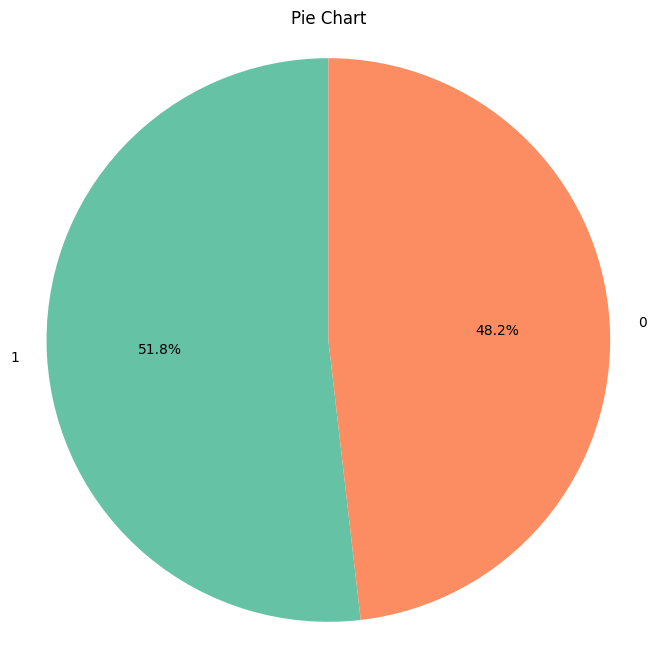

In [28]:
piechart_series(dataset[dataset['Male']==0]['Clicked on Ad'])

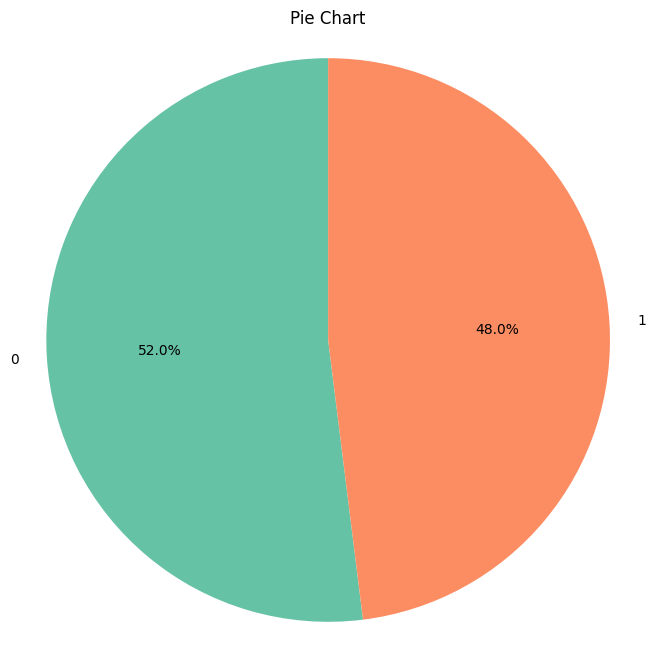

In [29]:
piechart_series(dataset[dataset['Male']==1]['Clicked on Ad'])

#### Observation: Significant Feature

## 5) Daily Internet Usage, Area Income, Age, Daily Time Spent on Site

In [30]:
dataset[['Daily Internet Usage', 'Area Income', 'Age', 'Daily Time Spent on Site']].describe().round(2)

,Daily Internet Usage,Area Income,Age,Daily Time Spent on Site
count,1000.00,1000.00,1000.00,1000.00
mean,180.00,55000.00,36.01,65.00
std,43.90,13414.63,8.79,15.85
min,104.78,13996.50,19.00,32.60
25%,138.83,47031.80,29.00,51.36
50%,183.13,57012.30,35.00,68.22
75%,218.79,65470.63,42.00,78.55
max,269.96,79484.80,61.00,91.43


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



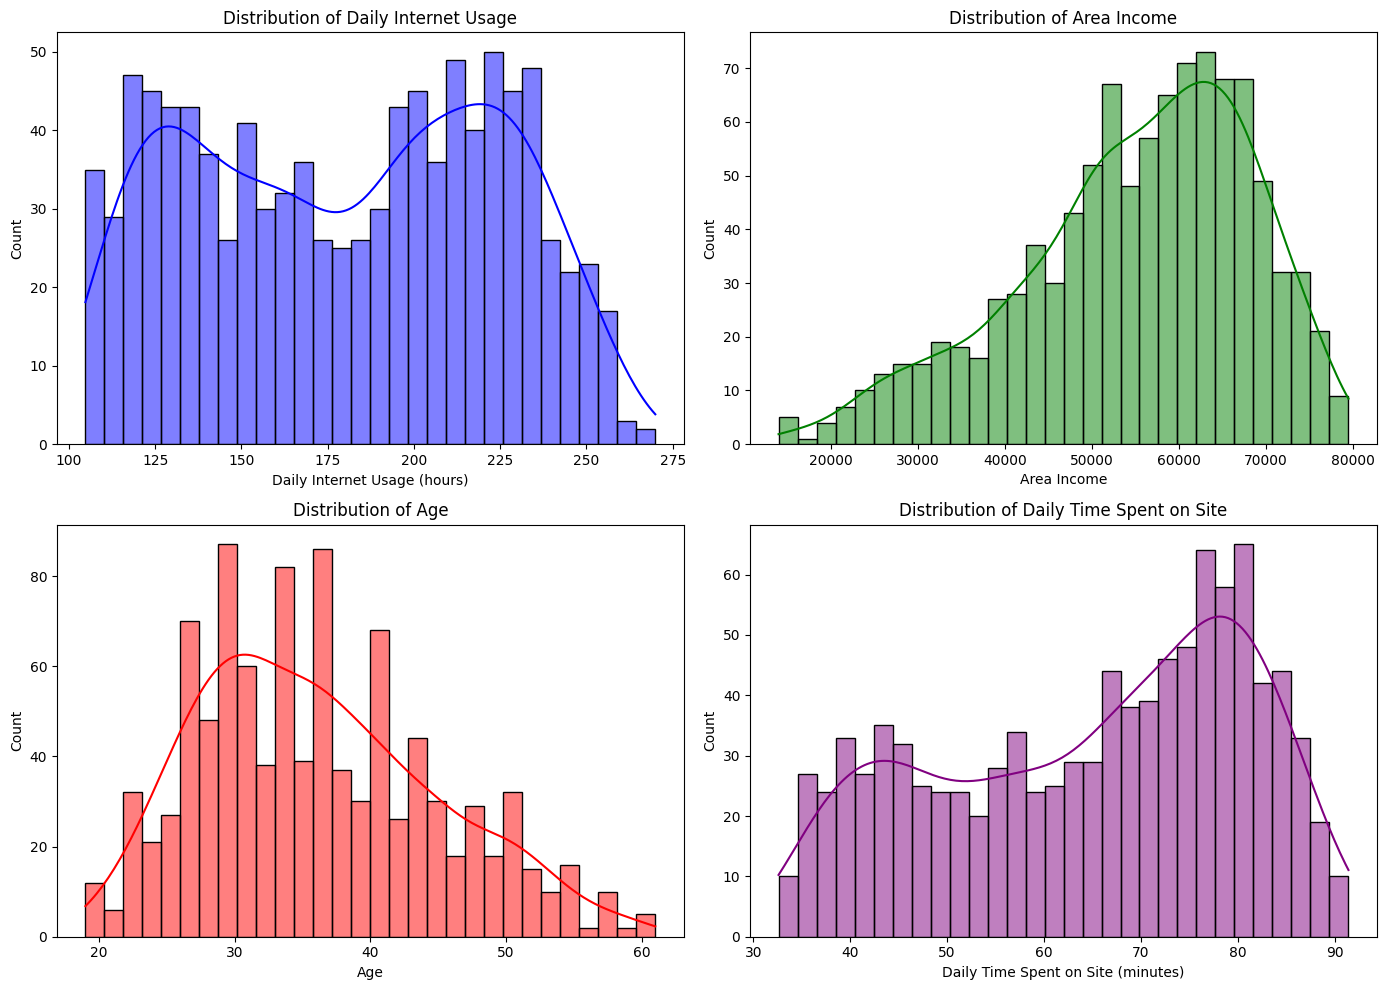

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Daily Internet Usage distribution
sns.histplot(dataset['Daily Internet Usage'], kde=True, ax=axes[0, 0], bins=30, color='blue')
axes[0, 0].set_title('Distribution of Daily Internet Usage')
axes[0, 0].set_xlabel('Daily Internet Usage (hours)')

# Area Income distribution
sns.histplot(dataset['Area Income'], kde=True, ax=axes[0, 1], bins=30, color='green')
axes[0, 1].set_title('Distribution of Area Income')
axes[0, 1].set_xlabel('Area Income')

# Age distribution
sns.histplot(dataset['Age'], kde=True, ax=axes[1, 0], bins=30, color='red')
axes[1, 0].set_title('Distribution of Age')
axes[1, 0].set_xlabel('Age')

# Daily Time Spent on Site distribution
sns.histplot(dataset['Daily Time Spent on Site'], kde=True, ax=axes[1, 1], bins=30, color='purple')
axes[1, 1].set_title('Distribution of Daily Time Spent on Site')
axes[1, 1].set_xlabel('Daily Time Spent on Site (minutes)')

plt.tight_layout()
plt.savefig('distribution_plot.png',dpi=300)
plt.show()

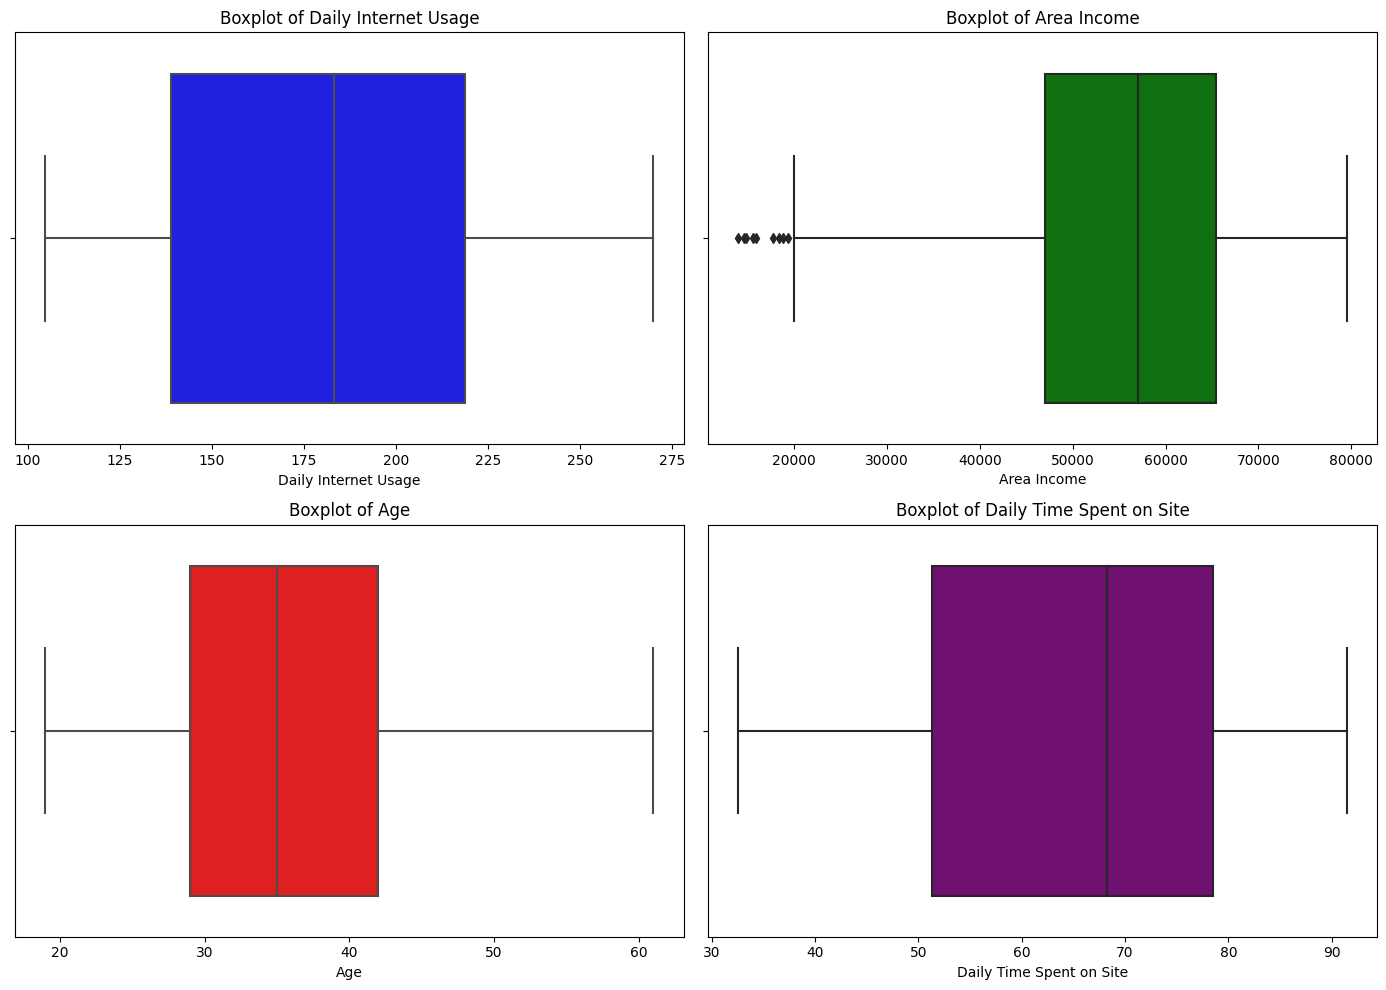

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Daily Internet Usage boxplot
sns.boxplot(x=dataset['Daily Internet Usage'], ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Boxplot of Daily Internet Usage')

# Area Income boxplot
sns.boxplot(x=dataset['Area Income'], ax=axes[0, 1], color='green')
axes[0, 1].set_title('Boxplot of Area Income')

# Age boxplot
sns.boxplot(x=dataset['Age'], ax=axes[1, 0], color='red')
axes[1, 0].set_title('Boxplot of Age')

# Daily Time Spent on Site boxplot
sns.boxplot(x=dataset['Daily Time Spent on Site'], ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Boxplot of Daily Time Spent on Site')

plt.tight_layout()
plt.savefig('box_plot_image.png', dpi=300)
plt.show()

### Outlier Configuration

In [33]:
outlier_points=dataset[dataset['Area Income']<20000]

In [34]:
print("No. of Outliers",outlier_points.shape[0])

No. of Outliers 10


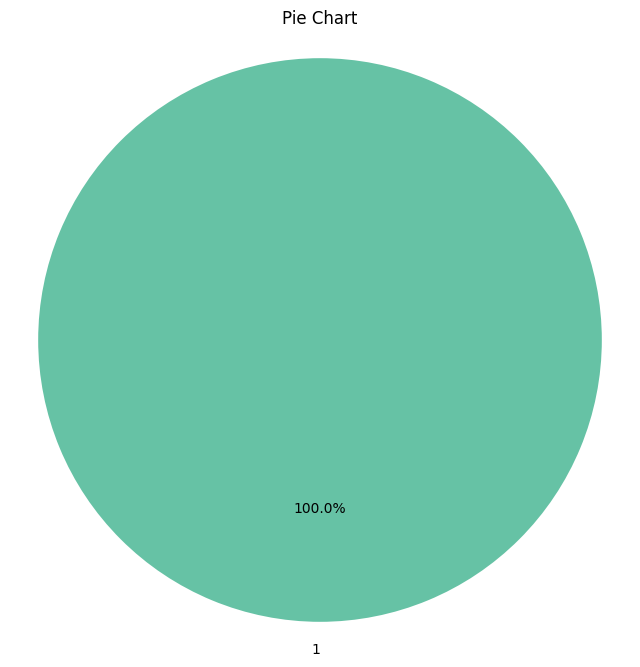

In [35]:
piechart_series(outlier_points['Clicked on Ad'])

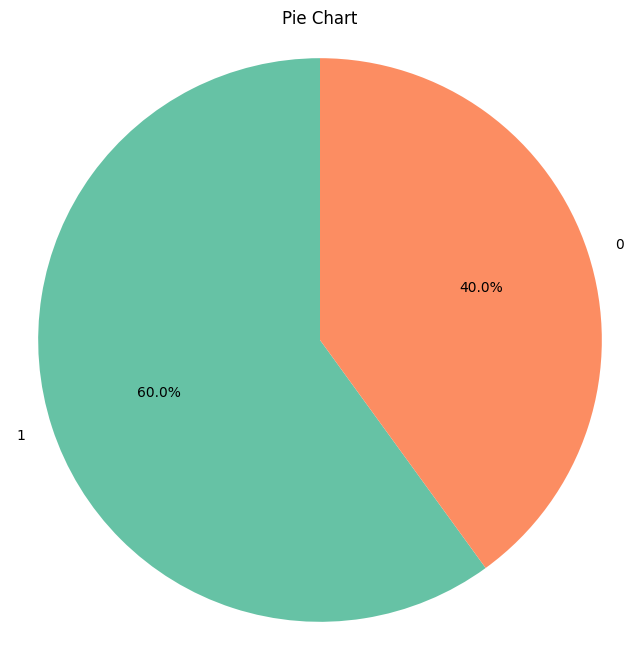

In [36]:
piechart_series(outlier_points['Male'])

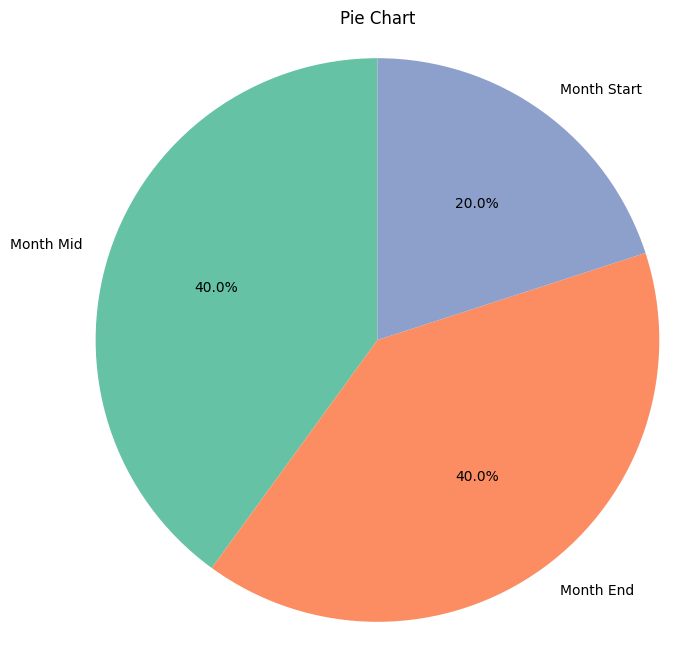

In [37]:
piechart_series(outlier_points['Month_Part'])

#### Observation: This has been observed that all the outliers always click on the ads and this observation is not affected by any other feature that significantly so we can declare the reason of being an outlier of area Income to be a causal reason for clicking on the Ad

#### Further Observations: Transformations Need to be applied to some of the features as to normalize them
The transformations and why are:

| Feature                  | Transformation Recommended                               | Rationale                                             |
|--------------------------|---------------------------------------------------------|-------------------------------------------------------|
| Daily Internet Usage     | Feature engineering (polynomial features) | Bimodal distribution requires specialized handling    |
| Area Income              | Negating and sqrt                                      | Reduces skewness from -0.65 to -0.05                    |
| Age                      | Log Transformation                                                    | Reduces skewness from 0.48 to -0.02          |
| Daily Time Spent on Site | Feature engineering (polynomial features) | Bimodal distribution requires specialized handling    |

# Removing Extra Entities and Finalizing Dataset

In [38]:
features_removed=[
    'City',
    'Country',
    'Timestamp',
    'Hour',
    'DayOfWeek',
    'Month',
    'Day',
    'Year',
    'Weekend',
    'Month_Part'
]

In [39]:
dataset=dataset[dataset['Area Income']>=20000].drop(features_removed,axis=1)

# Feature Engineering and Finalizing Dataset for training

In [40]:
dataset['Daily Internet Usage_squared']=dataset['Daily Internet Usage']**2
dataset['Daily Internet Usage_cubed']=dataset['Daily Internet Usage']**3
dataset['Daily Internet Usage_to_the_fourth_power']=dataset['Daily Internet Usage']**4

In [41]:
max_area_income_Value=dataset['Area Income'].max()

In [42]:
max_area_income_std=dataset['Area Income'].std()

In [43]:
dataset['Area Income_negated_sqrt']=np.sqrt(max_area_income_Value-dataset['Area Income']+(1.5*max_area_income_std))

Keeping 1.5*stdev of the feature added so as to accomodate a Area_income value greater than max upto 1.5*stdev without giving a NaN error due to sqrt function 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



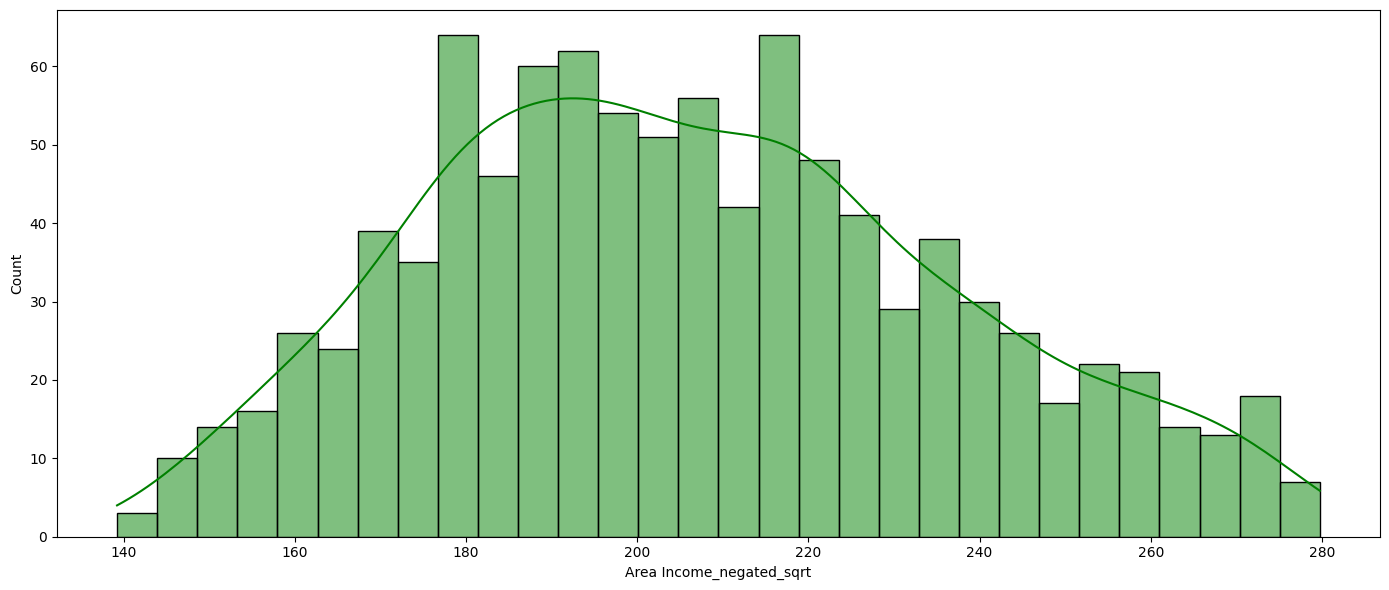

In [44]:
plotting(dataset['Area Income_negated_sqrt'])

In [45]:
dataset['Daily Time Spent on Site_squared']=dataset['Daily Time Spent on Site']**2
dataset['Daily Time Spent on Site_cubed']=dataset['Daily Time Spent on Site']**3
dataset['Daily Time Spent on Site_to_the_fourth_power']=dataset['Daily Time Spent on Site']**4

In [46]:
dataset['Age_log_transformed']=np.log(dataset['Age'])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



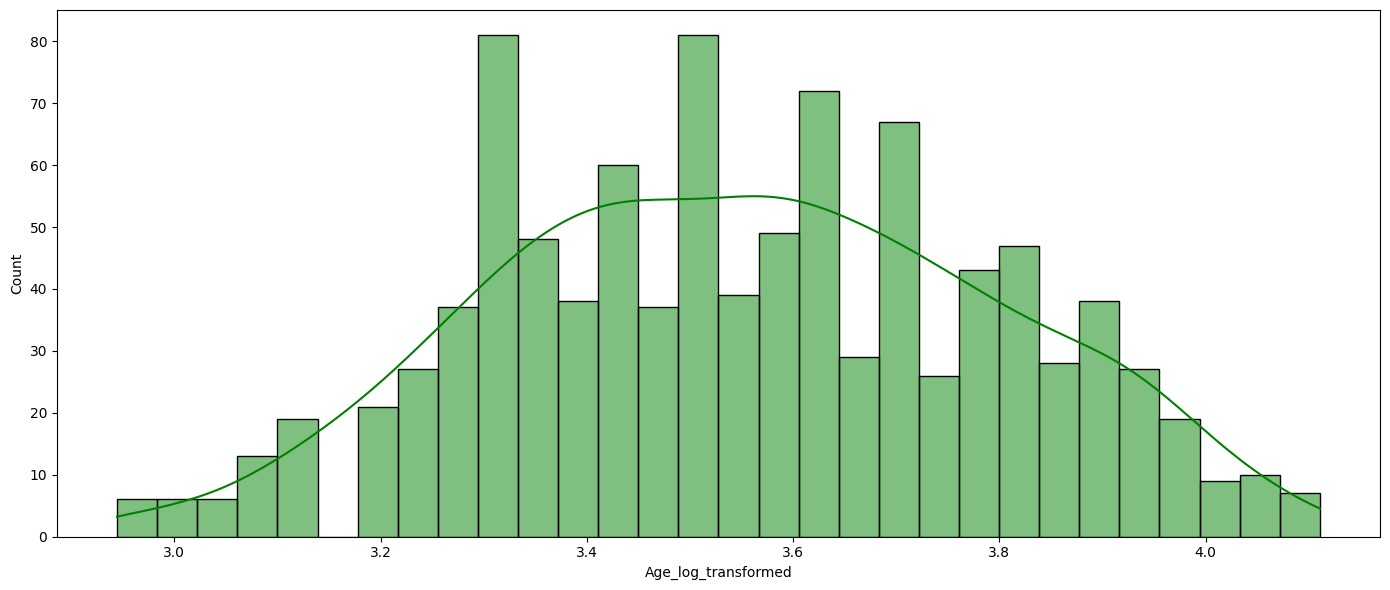

In [47]:
plotting(dataset['Age_log_transformed'])

In [48]:
dataset.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Male,Clicked on Ad,Time_of_Day,Daily Internet Usage_squared,Daily Internet Usage_cubed,Daily Internet Usage_to_the_fourth_power,Area Income_negated_sqrt,Daily Time Spent on Site_squared,Daily Time Spent on Site_cubed,Daily Time Spent on Site_to_the_fourth_power,Age_log_transformed
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,0,0,Night,65582.0881,1.679492e+07,4.301010e+09,192.430906,4754.1025,327795.367375,2.260149e+07,3.555348
1,80.23,31,68441.85,193.77,Monitored national standardization,1,0,Night,37546.8129,7.275446e+06,1.409763e+09,174.418186,6436.8529,516428.708167,4.143308e+07,3.433987
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,0,0,Evening,55932.2500,1.322798e+07,3.128417e+09,197.680585,4826.0809,335267.840123,2.329106e+07,3.258097
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,1,0,Night,60461.8921,1.486697e+07,3.655640e+09,209.898484,5498.2225,407693.198375,3.023045e+07,3.367296
4,68.37,35,73889.99,225.58,Robust logistical utilization,0,0,Night,50886.3364,1.147894e+07,2.589419e+09,158.030262,4674.4569,319592.618253,2.185055e+07,3.555348


In [49]:
dataset=pd.get_dummies(dataset,columns=['Time_of_Day'],dtype='int')

In [50]:
dataset.drop(['Age','Area Income'],axis=1,inplace=True)

## Handling Ad topic Line

As we can only fit our vectorizer on X_train and not whole to prevent Data Leakage, We will split the dataset now

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X=dataset.drop('Clicked on Ad',axis=1)
Y=dataset['Clicked on Ad']

In [53]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=69)
X_cv,X_test,Y_cv,Y_test=train_test_split(X_test,Y_test,test_size=0.5,random_state=69)

In [54]:
vectorizer = TfidfVectorizer(max_features=15)

In [55]:
tfidf_matrix = vectorizer.fit_transform(X_train['Ad Topic Line'])

# Convert the result to a DataFrame for easy inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray().astype(int), columns=vectorizer.get_feature_names_out())
X_train.reset_index(inplace=True)
X_train.drop('index',axis=1,inplace=True)
# Optionally, concatenate these features back to your original DataFrame
X_train = pd.concat([X_train, tfidf_df], axis=1)

In [56]:
X_train=X_train.drop('Ad Topic Line',axis=1)

# Final Checks and Scaling

In [57]:
X_train.corr().to_csv('Correlation.csv')

In [58]:
X_train.columns

Index(['Daily Time Spent on Site', 'Daily Internet Usage', 'Male',
       'Daily Internet Usage_squared', 'Daily Internet Usage_cubed',
       'Daily Internet Usage_to_the_fourth_power', 'Area Income_negated_sqrt',
       'Daily Time Spent on Site_squared', 'Daily Time Spent on Site_cubed',
       'Daily Time Spent on Site_to_the_fourth_power', 'Age_log_transformed',
       'Time_of_Day_Afternoon', 'Time_of_Day_Evening', 'Time_of_Day_Morning',
       'Time_of_Day_Night', 'based', 'configurable', 'customer', 'engineered',
       'face', 'focused', 'interface', 'line', 'multi', 'open', 'oriented',
       'solution', 'system', 'user', 'zero'],
      dtype='object')

In [59]:
X_train.drop([
    'Daily Internet Usage_squared',
    'Daily Internet Usage_cubed',
    'Daily Internet Usage_to_the_fourth_power',
    'Daily Time Spent on Site_squared',
    'Daily Time Spent on Site_cubed',
    'Daily Time Spent on Site_to_the_fourth_power'
],axis=1,inplace=True)

In [60]:
X_train.columns

Index(['Daily Time Spent on Site', 'Daily Internet Usage', 'Male',
       'Area Income_negated_sqrt', 'Age_log_transformed',
       'Time_of_Day_Afternoon', 'Time_of_Day_Evening', 'Time_of_Day_Morning',
       'Time_of_Day_Night', 'based', 'configurable', 'customer', 'engineered',
       'face', 'focused', 'interface', 'line', 'multi', 'open', 'oriented',
       'solution', 'system', 'user', 'zero'],
      dtype='object')

In [61]:
not_cat_cols=[
    'Daily Time Spent on Site',
    'Daily Internet Usage',
    'Area Income_negated_sqrt',
    'Age_log_transformed'
]

In [62]:
cat_cols=list(set(X_train.columns)-set(not_cat_cols))

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [64]:
scaler=StandardScaler()

In [65]:
transformed_not_cal_data=scaler.fit_transform(X_train[not_cat_cols])

In [66]:
scaled_X_train=pd.concat([pd.DataFrame(transformed_not_cal_data,columns=not_cat_cols),X_train[cat_cols]],axis=1)

In [67]:
pca = PCA(n_components=1, random_state=42)

In [68]:
scaled_X_train

,Daily Time Spent on Site,Daily Internet Usage,Area Income_negated_sqrt,Age_log_transformed,Time_of_Day_Night,face,oriented,configurable,multi,based,...,customer,zero,Time_of_Day_Afternoon,Time_of_Day_Evening,line,focused,solution,open,interface,Time_of_Day_Morning
0,0.710428,1.125851,-0.806403,-0.435981,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-0.938147,0.914628,-0.905087,-0.839014,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.178791,-0.987294,1.748676,-0.310264,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.055875,-0.632211,1.557036,-1.617936,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.023495,-1.291456,-0.389076,0.370219,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.279835,0.552694,-1.035722,-1.132462,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
590,1.465088,-0.693865,0.550821,0.044577,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
591,0.330530,1.712937,-0.060902,-0.435981,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
592,0.297803,0.894076,-1.230879,-0.700061,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [69]:
pca_data=pca.fit_transform(scaled_X_train[['Daily Time Spent on Site','Daily Internet Usage']])

In [70]:
X_train=pd.concat([pd.Series(pca_data.flatten(),name='pca_data'),scaled_X_train.drop(['Daily Time Spent on Site','Daily Internet Usage'],axis=1)],axis=1)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



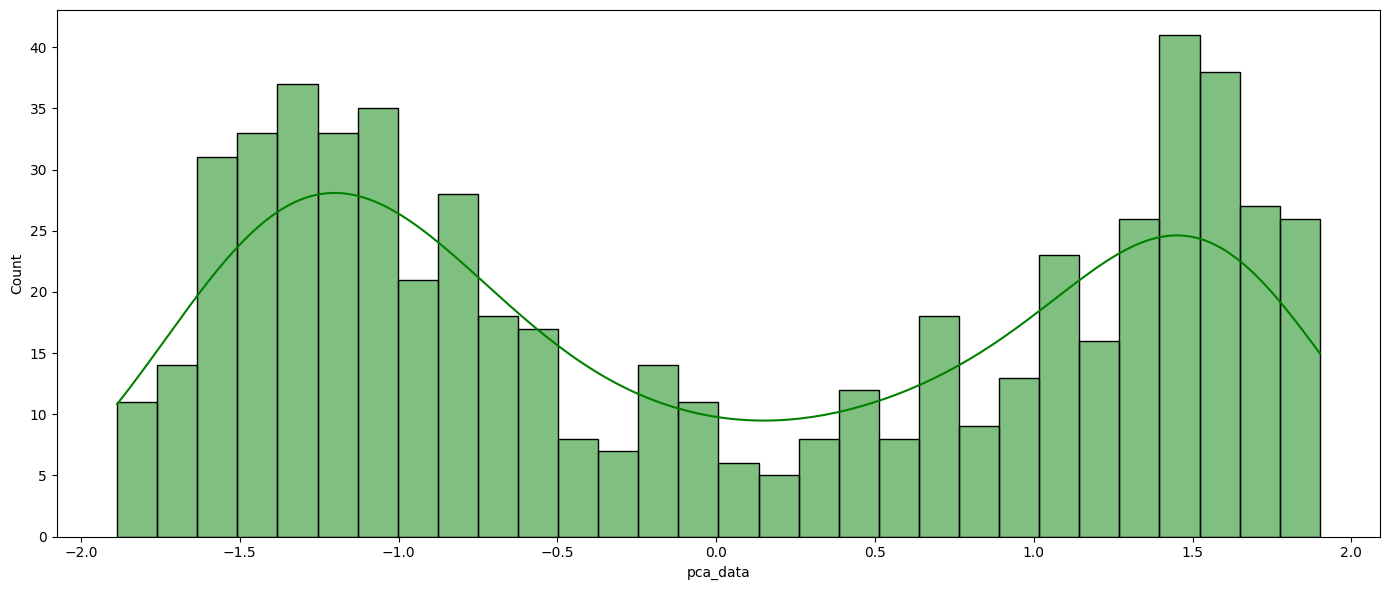

In [71]:
plotting(X_train['pca_data'])

As it has a similar distribution as both the combining features had, so creating polynomial features of the pca_data

In [72]:
X_train['pca_data_squared']=X_train['pca_data']**2
X_train['pca_data_cubed']=X_train['pca_data']**3
X_train['pca_data_to_the_fourth_power']=X_train['pca_data']**4

In [73]:
!mkdir dataset_final

In [74]:
X_train.to_csv('dataset_final/X_train.csv',index=False)
X_cv.to_csv('dataset_final/X_cv.csv',index=False)
X_test.to_csv('dataset_final/X_test.csv',index=False)
Y_train.to_csv('dataset_final/Y_train.csv',index=False)
Y_cv.to_csv('dataset_final/Y_cv.csv',index=False)
Y_test.to_csv('dataset_final/Y_test.csv',index=False)

In [75]:
!zip -r dataset_final.zip dataset_final/

  adding: dataset_final/ (stored 0%)
  adding: dataset_final/X_train.csv (deflated 64%)
  adding: dataset_final/X_test.csv (deflated 55%)
  adding: dataset_final/X_cv.csv (deflated 55%)
  adding: dataset_final/Y_test.csv (deflated 79%)
  adding: dataset_final/Y_train.csv (deflated 85%)
  adding: dataset_final/Y_cv.csv (deflated 79%)


In [76]:
!mkdir models_for_preprocessing

In [77]:
import joblib

# Save the models
joblib.dump(scaler, 'models_for_preprocessing/scaler.joblib')
joblib.dump(pca, 'models_for_preprocessing/pca.joblib')
joblib.dump(vectorizer, 'models_for_preprocessing/tfidf_vectorizer.joblib')

['models_for_preprocessing/tfidf_vectorizer.joblib']

In [78]:
!zip -r -0 models_for_preprocessing.zip models_for_preprocessing/

  adding: models_for_preprocessing/ (stored 0%)
  adding: models_for_preprocessing/pca.joblib (stored 0%)
  adding: models_for_preprocessing/tfidf_vectorizer.joblib (stored 0%)
  adding: models_for_preprocessing/scaler.joblib (stored 0%)
